<a href="https://colab.research.google.com/github/DavidRiemer02/DataMiningProj/blob/main/DataMiningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, array_distinct, desc
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType

from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from nltk.corpus import stopwords



Initialize spark context

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Prepare the Data

Read in the data

In [4]:
train = spark.read.csv('Data/train.csv', header=True, inferSchema=True)

In [5]:
train.printSchema()
train.show(10)

root
 |-- ItemID: integer (nullable = true)
 |-- Sentiment: integer (nullable = true)
 |-- SentimentText: string (nullable = true)

+------+---------+--------------------+
|ItemID|Sentiment|       SentimentText|
+------+---------+--------------------+
|     1|        0|                 ...|
|     2|        0|                 ...|
|     3|        1|              omg...|
|     4|        0|          .. Omga...|
|     5|        0|         i think ...|
|     6|        0|         or i jus...|
|     7|        1|       Juuuuuuuuu...|
|     8|        0|       Sunny Agai...|
|     9|        1|      handed in m...|
|    10|        1|      hmmmm.... i...|
+------+---------+--------------------+
only showing top 10 rows



Sentiment Count

+---------+-----+
|Sentiment|count|
+---------+-----+
|        1|56462|
|        0|43538|
+---------+-----+



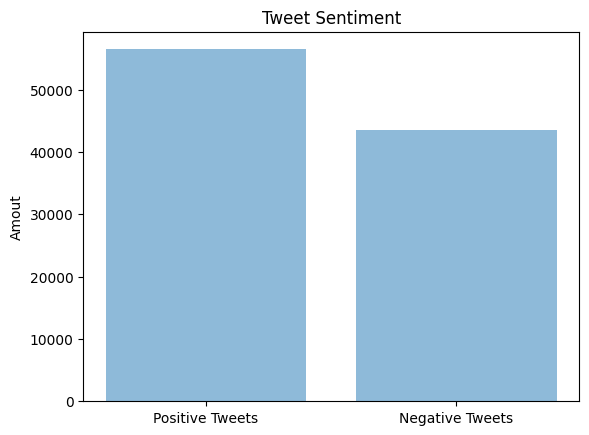

In [6]:
# get the count of each sentiment
train.groupBy("Sentiment").count().orderBy(col("count").desc()).show()

noPosTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[0][1]
noNegTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[1][1]

objects = ('Positive Tweets', 'Negative Tweets')
y_pos=(np.arange(len(objects)))
performance = (noPosTweets, noNegTweets)
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amout')
plt.title('Tweet Sentiment')
plt.show()


Remove stopwords we do not need from the train data \\
Transform the tweets into vectors of words

In [7]:
# Add a column with just words
regexTokenizer = RegexTokenizer(inputCol="SentimentText", outputCol="words", pattern="\\W")



# Remove the stop words
english_stop_words = stopwords.words('english')
english_stop_words.extend(['http', 'https', 'amp', 'rt', 't', 'c', 'the', 'www', 'com'])
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="filtered").setStopWords(english_stop_words)

#converts words into numerical values
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF]).fit(train)

dataset = pipeline.transform(train).select("Sentiment", "filtered", "features")
dataset = dataset.withColumn("Sentiment", dataset["Sentiment"].cast(IntegerType()))

dataset.show(truncate=False, n=5)
dataset.printSchema()

+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                   |features                                                                                                                                                         |
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                         |(262144,[74520,74989,125638],[1.0,1.0,1.0])                                                        

#Run Algorithms on the data

##Run Clustering-algorithms to find smiliar words

In [8]:
# Transform the data into a list of lists in order vor gensim and word2vec to work properly
sentences = [data[0] for data in dataset.
       select('filtered').collect()]

In [26]:
w2vModel = Word2Vec(sentences=sentences, vector_size=200, workers=1, seed=42)
w2vModel.save("word2vec.model")

In [27]:
w2vModel.wv.most_similar("fuck")

[('lame', 0.9682522416114807),
 ('bitch', 0.9641087651252747),
 ('lmao', 0.9640318155288696),
 ('_jayytee', 0.9591496586799622),
 ('uh', 0.9576287269592285),
 ('craziixlovee', 0.9569655656814575),
 ('trust', 0.9559251070022583),
 ('azeleen', 0.9549760222434998),
 ('chemicalzombie', 0.9548925161361694),
 ('hell', 0.9492998123168945)]

In [10]:
#vectors = w2vModel.wv[w2vModel.wv.key_to_index]
#from nltk.cluster import KMeansClusterer
#import nltk
#NUM_CLUSTERS=50
#kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
#assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)
#print (assigned_clusters)
##Print the words with their respective cluster numbers
#words = list(w2vModel.wv.key_to_index)
#for i, word in enumerate(words):
#    print (word + ":" + str(assigned_clusters[i]))
#Create a dataframe with Clusters as Column names and words as rows
#word_cluster_df = pd.DataFrame(list(zip(words, assigned_clusters)), columns=['word', 'cluster'])

In [11]:
#Retrieve the 750 most "important words" in the dataset
w2vModel.wv.index_to_key[:100]
#Fit a 2D PCA model to the vectors
vectors = w2vModel.wv[w2vModel.wv.key_to_index]
wordsArray = list(w2vModel.wv.key_to_index)[:750]
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

#Prepare a dataframe
words = pd.DataFrame(wordsArray)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_labeled =PCA_final[['word','x_values','y_values']]

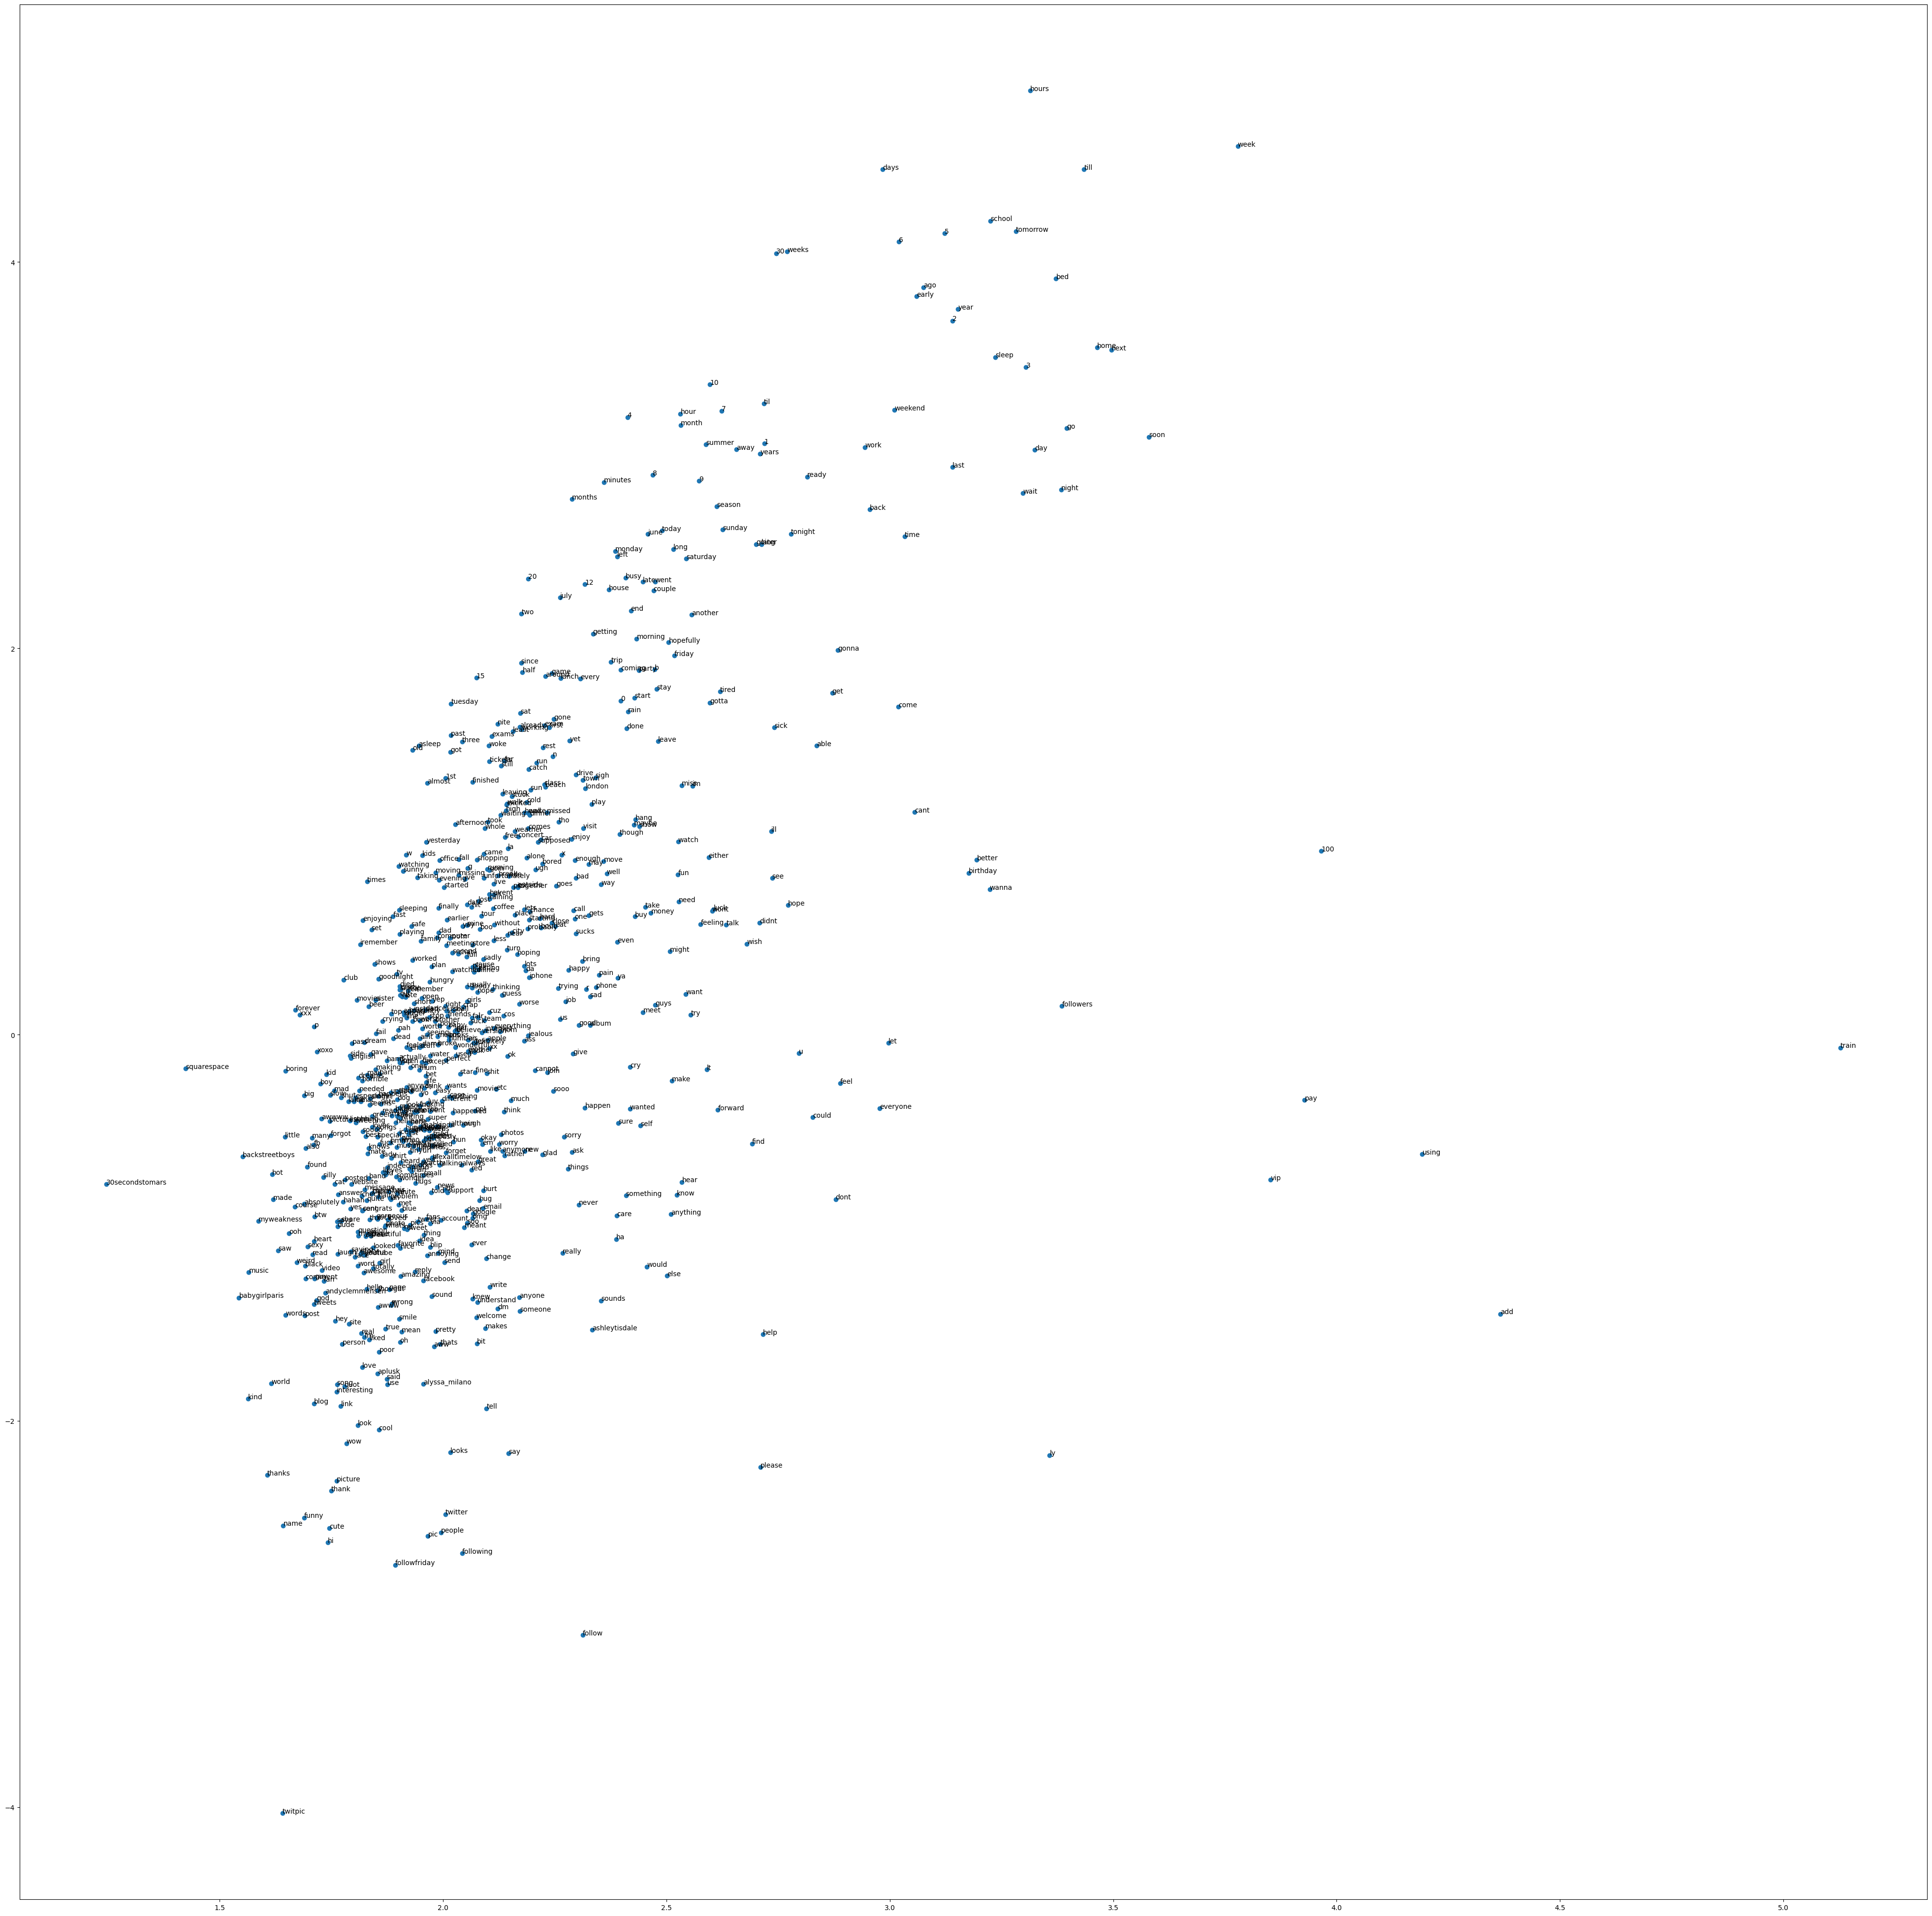

In [12]:
fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
#label the points with their respective words
for word, x, y in zip(PCA_data_labeled['word'], PCA_data_labeled['x_values'], PCA_data_labeled['y_values']):
    plt.annotate(word, (x, y))
plt.scatter(PCA_data_labeled['x_values'], PCA_data_labeled['y_values'])

In [13]:
#Run k-means and color the the points in the graph to their respective cluster
#Run k-means on the PCA_data_labeled dataframe
kmeans = KMeans(n_clusters=20)
kmeans.fit(PCA_data_labeled[['x_values','y_values']])
y_kmeans = kmeans.predict(PCA_data_labeled[['x_values','y_values']])

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


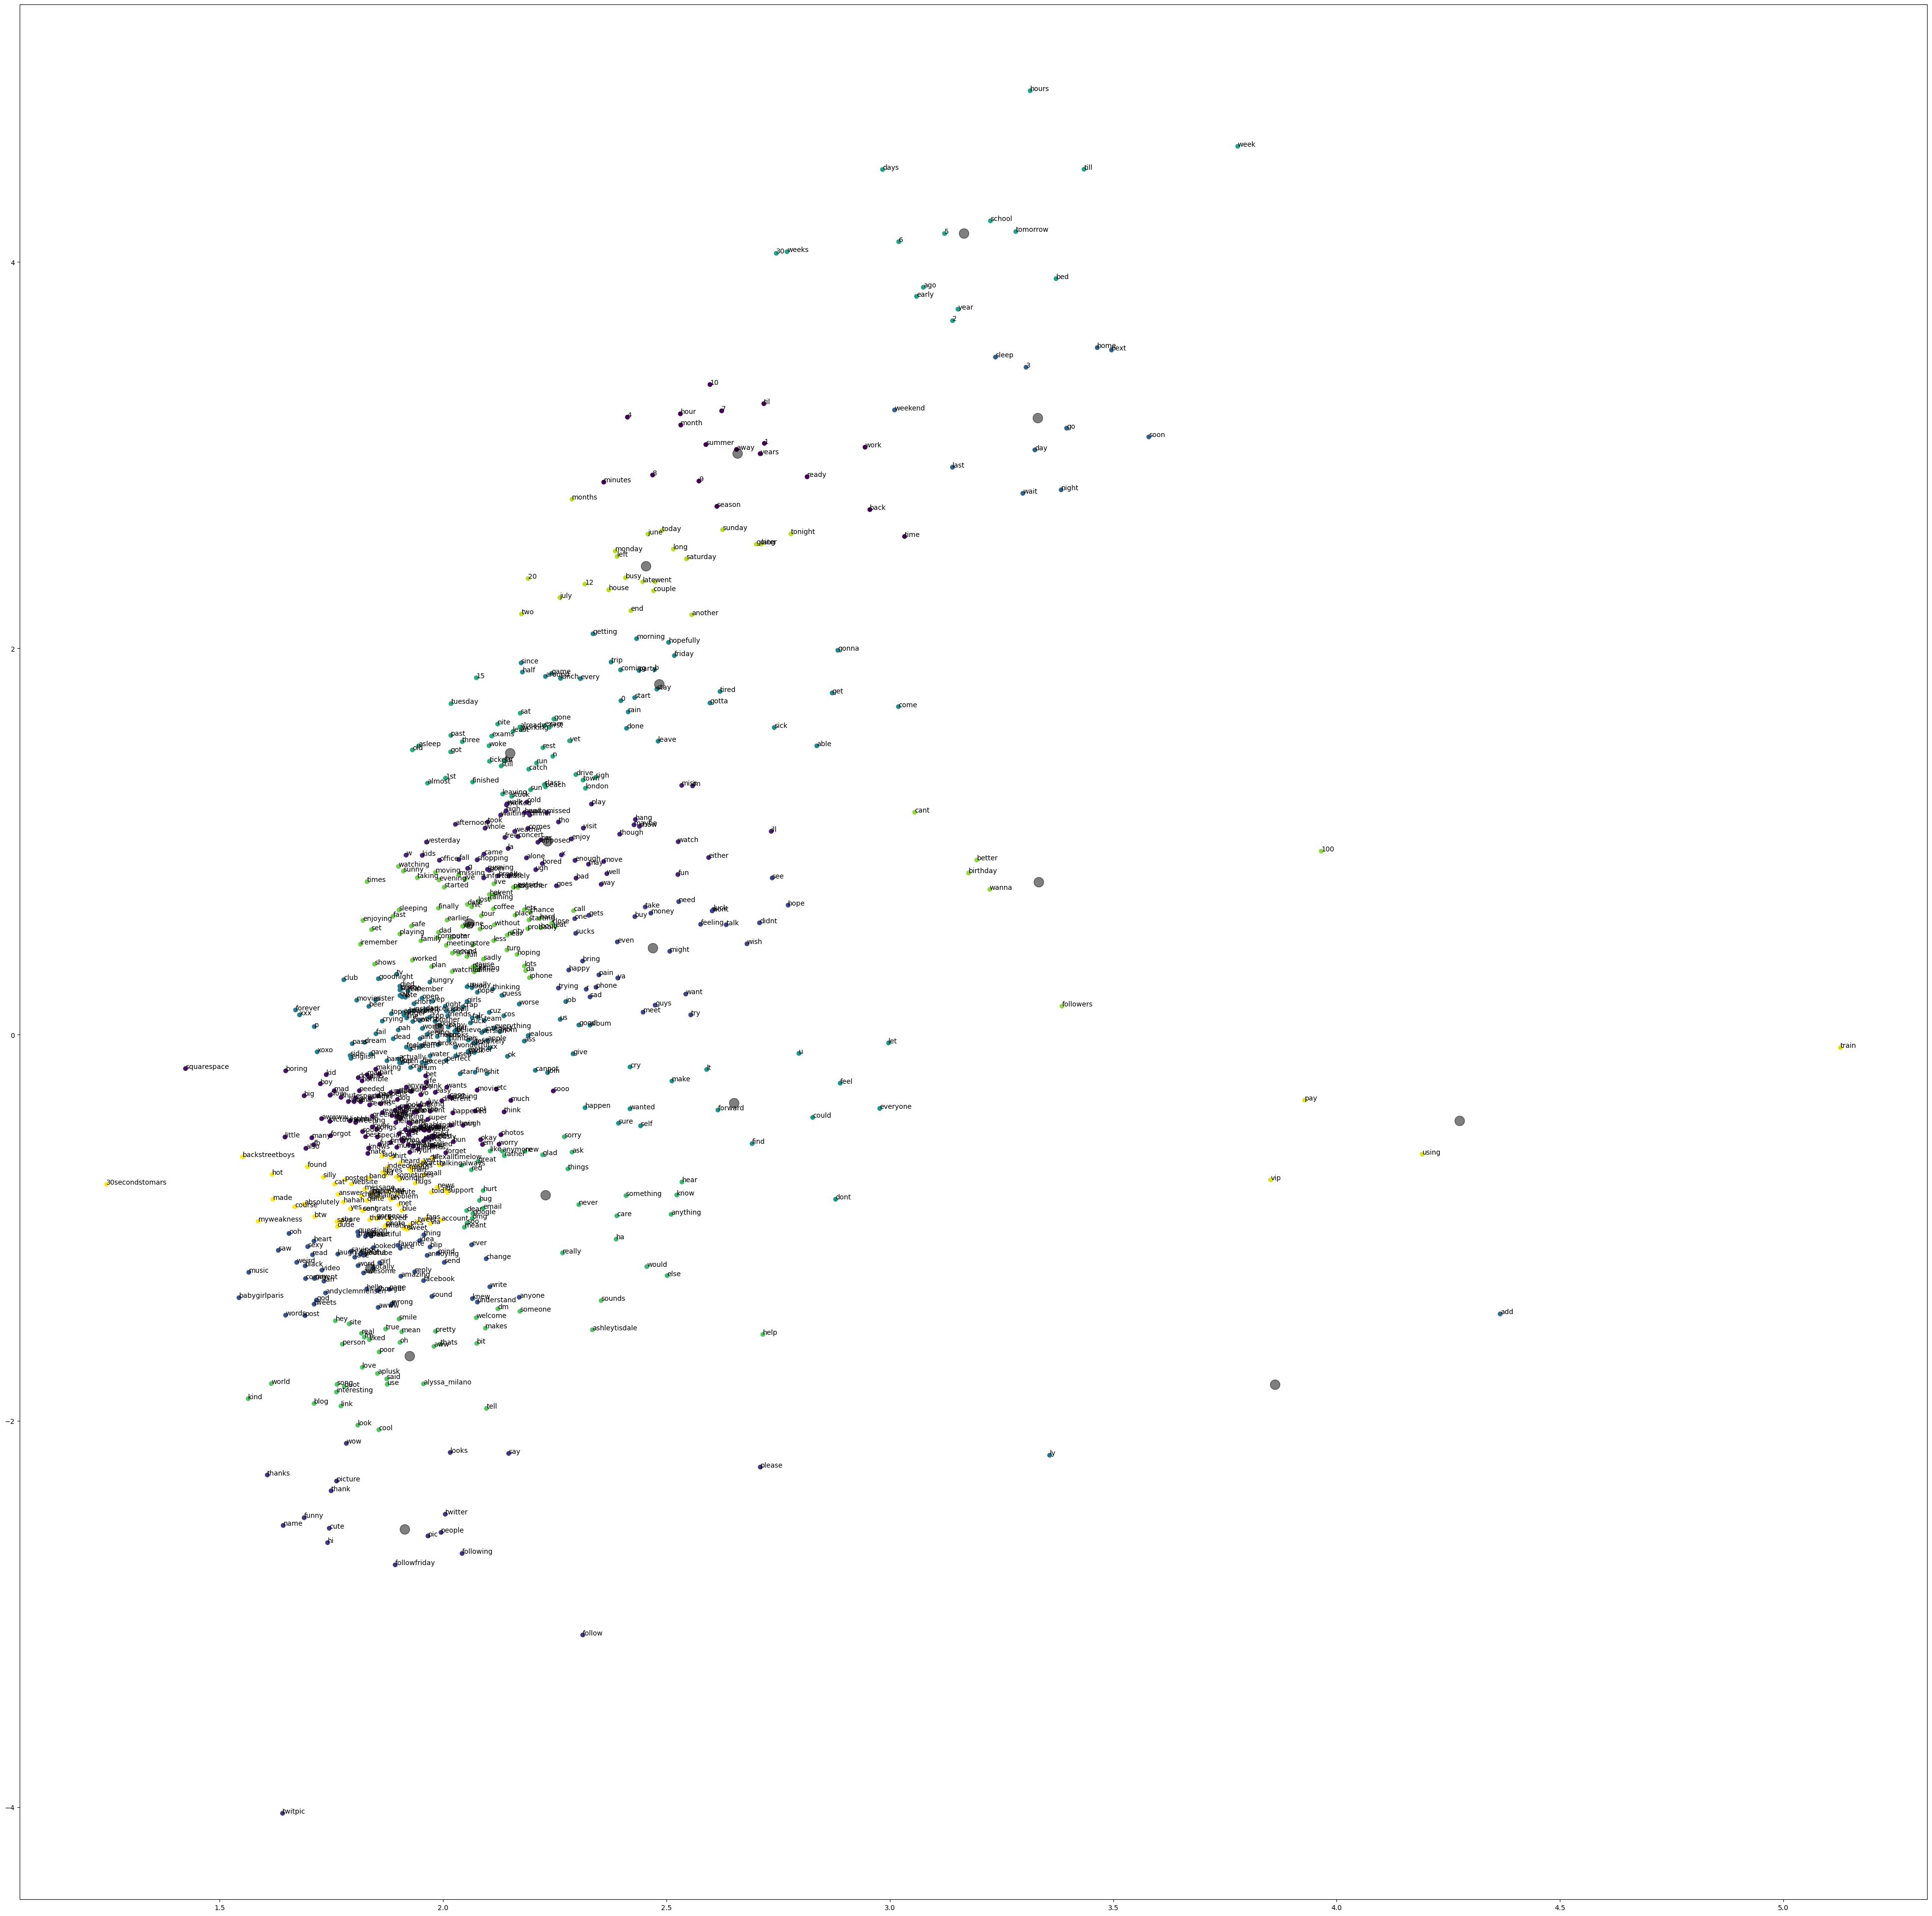

In [14]:
fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(PCA_data_labeled['x_values'], PCA_data_labeled['y_values'], c=y_kmeans, cmap='viridis')
#Plot the centroids of the clusters
centers = kmeans.cluster_centers_
for word, x, y in zip(PCA_data_labeled['word'], PCA_data_labeled['x_values'], PCA_data_labeled['y_values']):
    plt.annotate(word, (x, y))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

##Run A-propri on the word vetors, to see which words are most often used together

In [15]:
aprioriDF = dataset.withColumn("wordsWithoutDupes", array_distinct("filtered"))
#Number of unique words
fpGrowth = FPGrowth(itemsCol="wordsWithoutDupes", minSupport=0.002, minConfidence=0.2)
apriori_model = fpGrowth.fit(aprioriDF)

In [16]:
apriori_model.freqItemsets.sort(desc("freq")).show(apriori_model.freqItemsets.count())
print("Number of frequent itemsets: " + str(apriori_model.freqItemsets.count()))
apriori_model.associationRules.show()
print("Number of association rules: " + str(apriori_model.associationRules.count()))

+------------------+----+
|             items|freq|
+------------------+----+
|            [good]|5677|
|            [like]|5284|
|             [get]|5123|
|             [lol]|5118|
|            [know]|4442|
|               [u]|4331|
|            [quot]|4269|
|            [love]|4264|
|          [thanks]|4077|
|             [one]|3572|
|              [go]|3487|
|             [day]|3310|
|             [see]|3176|
|            [well]|3110|
|            [time]|2973|
|             [got]|2939|
|              [oh]|2896|
|           [think]|2833|
|            [haha]|2779|
|              [im]|2760|
|          [really]|2660|
|            [hope]|2653|
|           [going]|2601|
|            [work]|2543|
|           [sorry]|2497|
|           [still]|2376|
|            [back]|2364|
|            [yeah]|2329|
|            [want]|2249|
|           [would]|2231|
|           [today]|2225|
|            [much]|2206|
|           [great]|2133|
|            [need]|2023|
|            [miss]|2005|
|           

##Train the model to predict Sentiment on the test data

In [17]:
#Split training and Testing
split_data=train.randomSplit([0.7,0.3])
trainSplit=split_data[0]

#label in test renamed to true label
testSplit=split_data[1]

trainSplit = pipeline.transform(trainSplit).select("Sentiment", "filtered", "features")
testSplit = pipeline.transform(testSplit).select("Sentiment", "filtered", "features")

#Count the number of training tweets and testing tweets
print("Number of training tweets: " + str(trainSplit.count()))
print("Number of testing tweets: " + str(testSplit.count()))

trainSplit.show(5, truncate=False)
testSplit.show(5, truncate=False)

Number of training tweets: 70322
Number of testing tweets: 29678
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                   |features                                                                                                                                                         |
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[missed, new, moon, trailer]                                                               |(262144,[64344,89833,165360,201103

In [18]:
lr = LogisticRegression(labelCol = 'Sentiment', featuresCol='features', maxIter=100, regParam=0.01)
lrModel = lr.fit(trainSplit)
print("Done")

raw_prediction = lrModel.transform(testSplit)
raw_prediction.printSchema()

Done
root
 |-- Sentiment: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [19]:
Final_prediction = raw_prediction.select("filtered", "prediction", "Sentiment")
Final_prediction.show(n=4, truncate = False)

+-----------------------+----------+---------+
|filtered               |prediction|Sentiment|
+-----------------------+----------+---------+
|[sad, apl, friend]     |0.0       |0        |
|[omg, already, 7, 30]  |0.0       |1        |
|[worry, much]          |1.0       |0        |
|[must, think, positive]|1.0       |0        |
+-----------------------+----------+---------+
only showing top 4 rows



In [20]:
#Count the accuracy
correctPrediction = Final_prediction.filter(Final_prediction['prediction'] == Final_prediction['Sentiment']).count()
print("Number of correct predictions: " + str(correctPrediction))
Accuracy = correctPrediction/testSplit.count()*100
print("Accuracy: " + str(Accuracy))

Number of correct predictions: 20459
Accuracy: 68.93658602331693


In [21]:
sc.stop()